Load data into dataframe

In [ ]:
import numpy as np

In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)
import os
os.chdir("drive/My Drive/cbio_data")
!ls

Mounted at /content/drive
aml_data_clinical_patient.txt			  nr_system_matrix_brca_tcga_2012.png
aml_data_mrna_seq_v2_rsem.txt			  ohsu_aml_data_clinical_patient.txt
bc_data_clinical_patient.txt			  ohsu_aml_data_mrna_seq_rpkm.txt
bc_data_mrna_agilent_microarray.txt		  pathways_brca_tcga_2012.png
bc_data_mrna_seq_v2_rsem.txt			  perturb-matrix1.png
data						  perturb_matrix_brca_tcga_2012.png
diffusivity_pancreas_cyclins.png		  perturb_matrix_ohsu_aml_2022.png
diffusivity_pancreas_latent_time.png		  progression_pathways_ohsu_aml.png
filtered_v2_nr_perturb_matrix_brca_tcga_2012.png  recomb_nr_perturb_matrix_ohsu_aml.png
metastasis_pathways_brca_tcga_2012.png		  recomb_nr_system_matrix_ohsu_aml.png
nr2_perturb_matrix_brca_tcga_2012.png		  scdata_average_error.png
nr2_system_matrix_brca_tcga_2012.png		  scdata_cyclin_latent_corr.png
nr3_perturb_matrix_brca_tcga_2012.png		  system_matrix_aml_ohsu_2022.png
nr_perturb_matrix_brca_tcga_2012.png		  system_matrix_brca_tcga_2012.png
nr_perturb_m

In [ ]:
import pandas as pd
file_name = 'ohsu_aml_data_mrna_seq_rpkm.txt'
df = pd.read_csv(file_name,sep='\t',header=(0))

In [ ]:
file_name = 'ohsu_aml_data_clinical_patient.txt'
clinical_df = pd.read_csv(file_name,sep='\t',header=(0)).drop(index=[0,1,2,3])

Reference vs pathological data

In [ ]:
temp=pd.concat([clinical_df['#Patient Identifier'],pd.to_numeric(clinical_df['Specific Diagnosis At Inclusion'], errors='ignore')], axis=1).reset_index()

In [ ]:
# samples for patients that survived >4yrs

ref_data = temp[temp['Specific Diagnosis At Inclusion']>='AML with mutated CEBPA']

In [ ]:
# samples for patients that survived <3months

path_data = temp[temp['Specific Diagnosis At Inclusion']=='AML with mutated NPM1']

Reference and pathological data columns

In [ ]:
# pick column/sample names in the rna-seq data that correspond to reference set
# dataset specific idiosyncracies may be present

ref_cols = [sub for sub in df.columns[2:].tolist() if sub[0:18] in ref_data['#Patient Identifier'].tolist()]

In [ ]:
# pick column/sample names in the rna-seq data that correspond to reference set
# dataset specific idiosyncracies may be present

path_cols = [sub for sub in df.columns[2:].tolist() if sub[0:18] in path_data['#Patient Identifier'].tolist()]

Find most variable genes [optional step (for computational tractability)]

Nuclear Receptors

In [ ]:
nuclear_receptors = ['AR', 'ESR1', 'ESR2', 'ESRRA', 'ESRRB', 'ESRRG', 'HNF4A', 'HNF4G', 'NR0B1', 'NR0B2', 'NR1D1', 'NR1D2', 'NR1H2', 'NR1H3', 'NR1H4', 'NR1I2', 'NR1I3', 'NR2C1', 'NR2C2', 'NR2E1', 'NR2E3', 'NR2F1', 'NR2F2', 'NR2F6', 'NR3C1', 'NR3C2', 'NR4A1', 'NR4A2', 'NR4A3', 'NR5A1', 'NR5A2', 'NR6A1', 'NRF1', 'PGR', 'PPARA', 'PPARD', 'PPARG', 'RARA', 'RARB', 'RARG', 'RORA', 'RORB', 'RORC', 'RXRA', 'RXRB', 'RXRG', 'THRA', 'THRB', 'VDR']

In [ ]:
selected_rows = [item for sublist in [df[df['Hugo_Symbol']==e].index.to_list() for e in nuclear_receptors] for item in sublist]

In [ ]:
list(set(nuclear_receptors)-set(df['Hugo_Symbol'].to_list()))

['NR2E1',
 'NR0B1',
 'NR0B2',
 'HNF4G',
 'HNF4A',
 'NR1I3',
 'NR2E3',
 'PGR',
 'RXRG',
 'NR1H4',
 'ESRRG']

Filter selected genes i.e., rows

In [ ]:
#add indices for ccna1 and ccnd1 if not present already
selected_rows.append(5814)
selected_rows.append(3317)

In [ ]:
# reference dataframe

filtered_ref_df=df[ref_cols].iloc[selected_rows]

In [ ]:
# pathological dataframe

filtered_path_df=df[path_cols].iloc[selected_rows]

Search for indiex of specific cyclins

In [ ]:
filtered_ref_df.index.get_indexer(df.index[df['Hugo_Symbol']=='CCNA1'])

array([38])

In [ ]:
filtered_ref_df.index.get_indexer(df.index[df['Hugo_Symbol']=='CCND1'])

array([39])

Sort by age and compute diffusivity matrix

In [ ]:
ref_rna_seq = filtered_ref_df[filtered_ref_df.columns].T.values.tolist()
path_rna_seq = filtered_path_df[filtered_path_df.columns].T.values.tolist()

In [ ]:
# assumes input is a list of lists with column 0 being the sample ids and
#column nos.; ccna_pos, ccnd_pos being the indices of ccna1 and ccnd1
ccna_pos=38;
ccnd_pos=39;
def SortByStage(list_):
    cell_age = 100*list_[ccna_pos] - 10*list_[ccnd_pos]
    return cell_age;

In [ ]:
ref_rna_seq.sort(key=SortByStage)
path_rna_seq.sort(key=SortByStage)

In [ ]:
# compute covariance matrix for increments i.e., diffusivity matrix

def ComputeDiffusivity(rna_seq):
  A=[]
  R=list(map(list, zip(*rna_seq)))
  for i in np.arange(len(R)):
    A.append([x - R[i][j - 1] for j, x in enumerate(R[i])][1:])
  cov_matrix = np.cov(A, bias=True)
  return cov_matrix;

Solve sensing problem to recover sparse dynamical system

In [ ]:
import cvxpy as cvx
import cvxopt

In [ ]:
"""
 Compute the Sparse dynamical system underlying the unperturbed DNA replication
"""
def SolveSensingProblem(Sigma, Diffusivity,noise_level=0.01):
  x = cvx.Variable(Sigma.shape)
  ub_constraints=[]
  for j in np.arange(Sigma.shape[0]):
    for i in np.arange(Sigma.shape[0]):
      ub_constraints+=[(Sigma @ x.T)[i,j]+ (x @ Sigma)[i,j] - 2 * Diffusivity[i,j] <= noise_level];
  lb_constraints=[]
  for j in np.arange(Sigma.shape[0]):
    for i in np.arange(Sigma.shape[0]):
      lb_constraints+=[(Sigma @ x.T)[i,j]+ (x @ Sigma)[i,j] - 2 * Diffusivity[i,j] >= -noise_level];
  # optimization problem
  prob = cvx.Problem(cvx.Minimize(cvx.mixed_norm(x,2,1)), ub_constraints+lb_constraints)
  result = prob.solve(solver=cvx.ECOS, verbose=True)

  # Print result.
  print("The optimal value is", prob.value)
  print("A solution x is")
  print(x.value)
  return x.value;

Use recovered dynamical system to solve for critical separator genes

In [ ]:
def ComputeReferenceDistribution(ref_df):
  mu=ref_df.mean(axis=1)
  return mu.tolist();

In [ ]:
def ComputeReferenceNoise(ref_df):
  std_dev=ref_df.std(axis=1)
  return std_dev.tolist();

In [ ]:
# returns a matrix k \times #genes
def ComputeReferenceDistributionMatrix(ref_df, k):
  r=ComputeReferenceDistribution(ref_df);
  Y=[]
  for i in np.arange(k):
    Y.append(r);
  return np.array(Y);

In [ ]:
# returns a matrix #columns(path_df)\times #genes

def ComputePerturbationsToDistribution(path_df, ref_dist):
  if len(path_df.iloc[:,[0]].values.tolist())!=len(ref_dist):
    print("unequal dimensions")
    return 0;
  Y=[]
  for i in np.arange(len(path_df.columns)):
    Y.append((np.array(path_df.iloc[:,[i]].values.tolist()).reshape(len(ref_dist),1)-np.array(ref_dist).reshape(len(ref_dist),1)).flatten().tolist())
  return np.array(Y);

In [ ]:
"""
Compute the perturbation in the dynamical system due to disease process
noise_level should be set around std_dev(Diffusivity)/#rows(Diffusivity)
"""
def ComputeCanonicalPerturbation(A, C, Sigma, epsilon=0.1, noise_level=0.01):
  # Define and solve the CVXPY problem.
  prob_size=Sigma.shape[0]
  x = cvx.Variable((prob_size, prob_size))
  ub_constraints=[]
  for j in np.arange(prob_size):
    for i in np.arange(prob_size):
      ub_constraints += [-(Sigma @ x.T)[i,j] - (x @ Sigma)[i,j] + ((A @ C)[i,j] + (C @ A.T)[i,j])/epsilon <= noise_level];
  lb_constraints=[]
  for j in np.arange(prob_size):
    for i in np.arange(prob_size):
      lb_constraints+=[-(Sigma @ x.T)[i,j] - (x @ Sigma)[i,j] + ((A @ C)[i,j] + (C @ A.T)[i,j])/epsilon >= -noise_level];
  prob = cvx.Problem(cvx.Minimize(cvx.norm(cvx.vec(x),1)), ub_constraints+lb_constraints)
  result = prob.solve(solver=cvx.ECOS, verbose=True)

  # Print result.
  print("The optimal value is", prob.value)
  print("A solution x is")
  print(x.value)

  return x.value;

Main loop of algorithm

A. Assumes data already preprocessed:
1.   Separate pathological and reference dataframes
2.   Sequentialize data using cyclin expressions




B. Recover underlying dynamical system

In [ ]:
# compute covariance matrix for ref and path rna seq data
R=list(map(list, zip(*ref_rna_seq)))
Sigma_ref = np.cov(R, bias=True)
R=list(map(list, zip(*path_rna_seq)))
Sigma_path = np.cov(R, bias=True)

In [ ]:
Diffusivity=ComputeDiffusivity(ref_rna_seq)

In [ ]:
A = SolveSensingProblem(Sigma_ref, Diffusivity)

                                     CVXPY                                     
                                     v1.3.2                                    
(CVXPY) Nov 01 01:50:23 AM: Your problem has 1600 variables, 3200 constraints, and 0 parameters.
(CVXPY) Nov 01 01:50:23 AM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Nov 01 01:50:23 AM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Nov 01 01:50:23 AM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Nov 01 01:50:24 AM: Compiling problem (target solver=ECOS).
(CVXPY) Nov 01 01:50:24 AM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffi

In [ ]:
df['Hugo_Symbol'].iloc[filtered_ref_df.index]

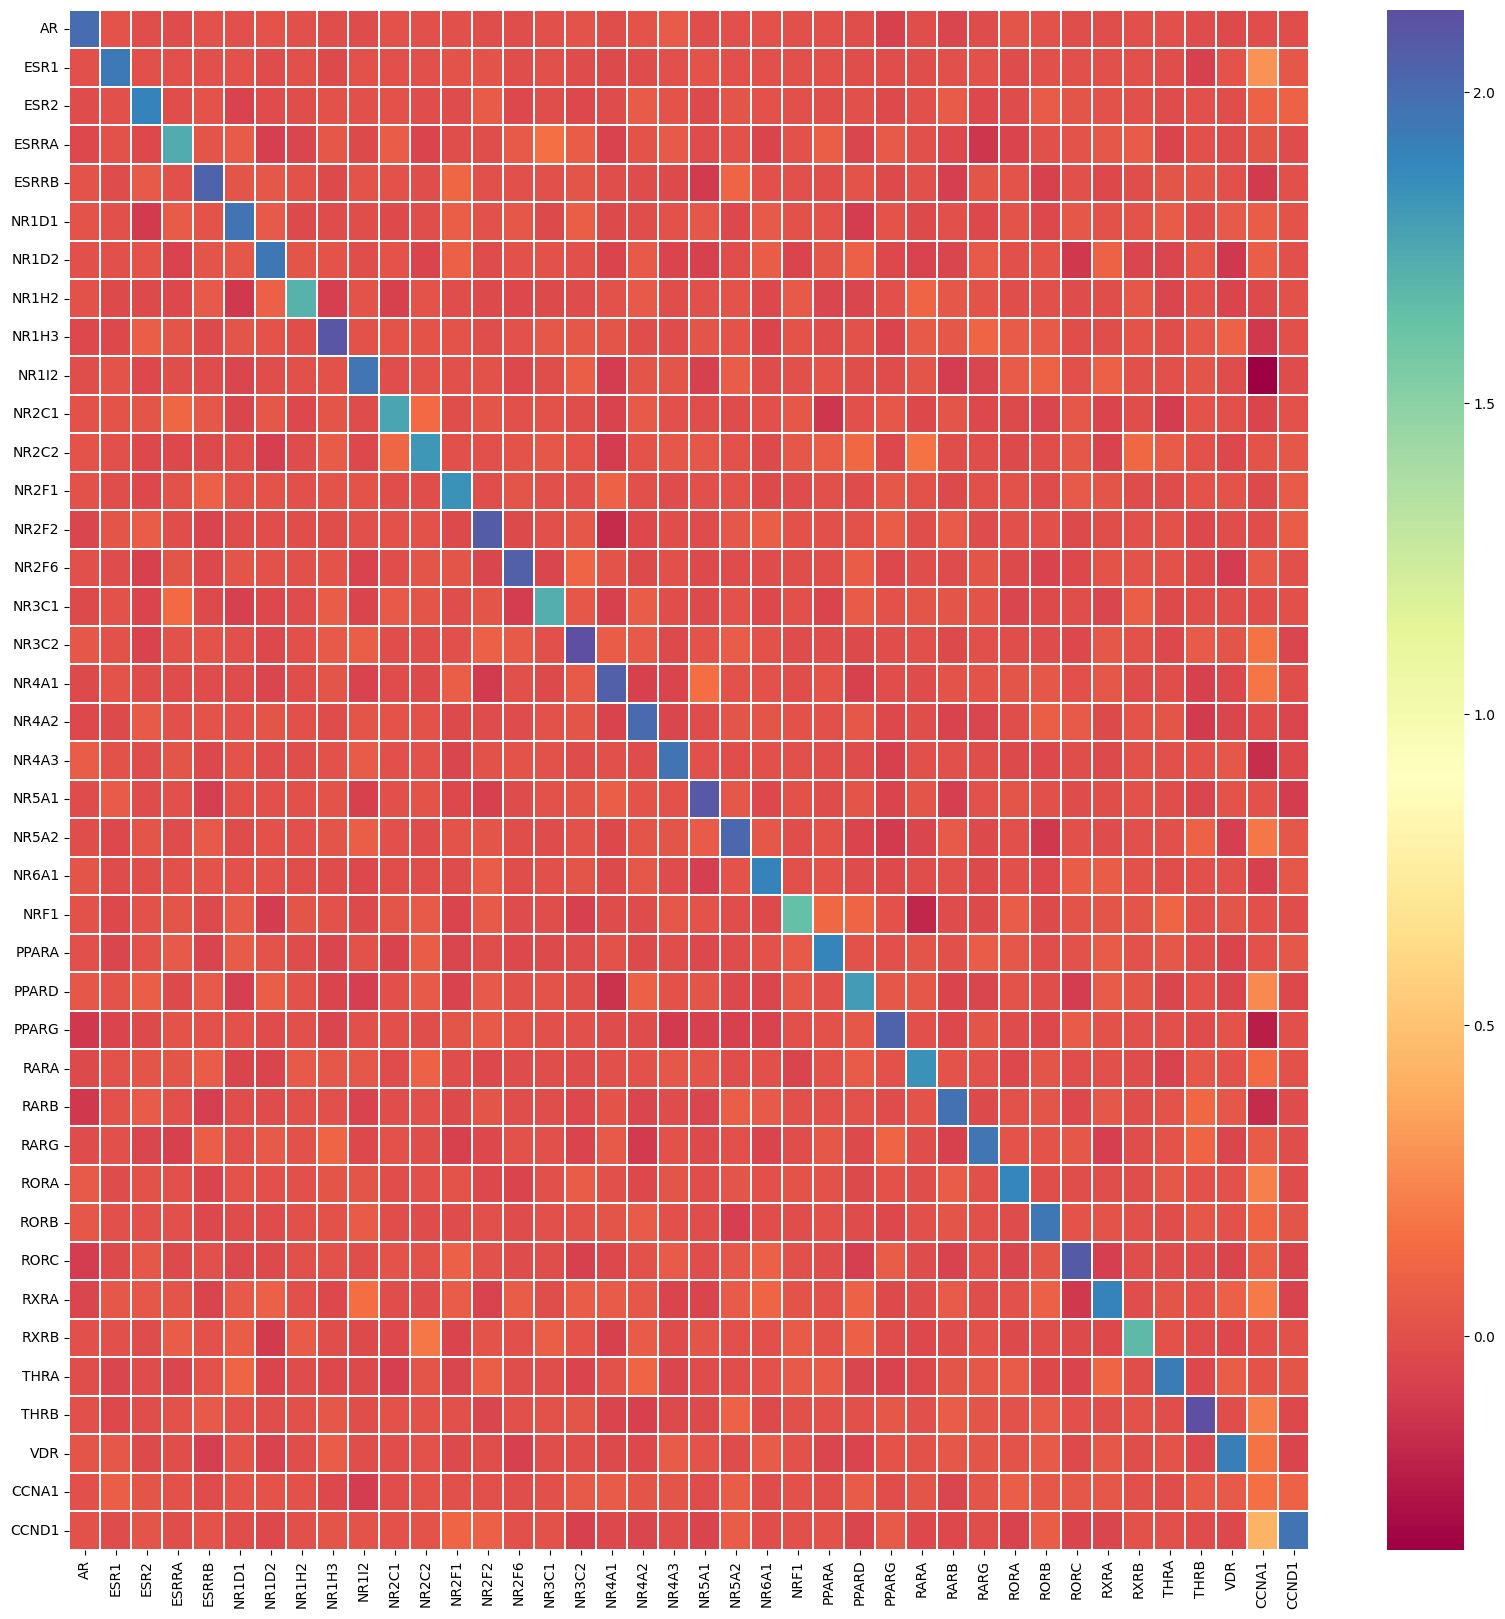

In [ ]:
import seaborn as sn
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 20))
#colormap=sn.color_palette("vlag", as_cmap=True)
colormap=sn.color_palette("Spectral", as_cmap=True)
hm = sn.heatmap(data = A, linewidths=.05,cmap=colormap)
hm.set_xticklabels(df['Hugo_Symbol'].iloc[filtered_ref_df.index], rotation = 90)
hm.set_yticklabels(df['Hugo_Symbol'].iloc[filtered_ref_df.index], rotation = 0)

# displaying the plotted heatmap
#plt.show()
from pylab import savefig
figure = hm.get_figure()
figure.savefig('recomb_nr_system_matrix_ohsu_aml.png', dpi=400)

C. Compute perturbation of pathological data from reference data


*   Check for inf in filtered_path_df and filtered_ref_df
*   Replace inf by -K, K<< min_value



In [ ]:
C = Sigma_path - Sigma_ref
B=ComputeCanonicalPerturbation(A, C, Sigma_ref, epsilon=0.1, noise_level=0.01)

                                     CVXPY                                     
                                     v1.3.2                                    
(CVXPY) Nov 01 01:52:04 AM: Your problem has 1600 variables, 3200 constraints, and 0 parameters.
(CVXPY) Nov 01 01:52:04 AM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Nov 01 01:52:04 AM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Nov 01 01:52:04 AM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Nov 01 01:52:05 AM: Compiling problem (target solver=ECOS).
(CVXPY) Nov 01 01:52:05 AM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffi

D. Plot perturbation heatmap

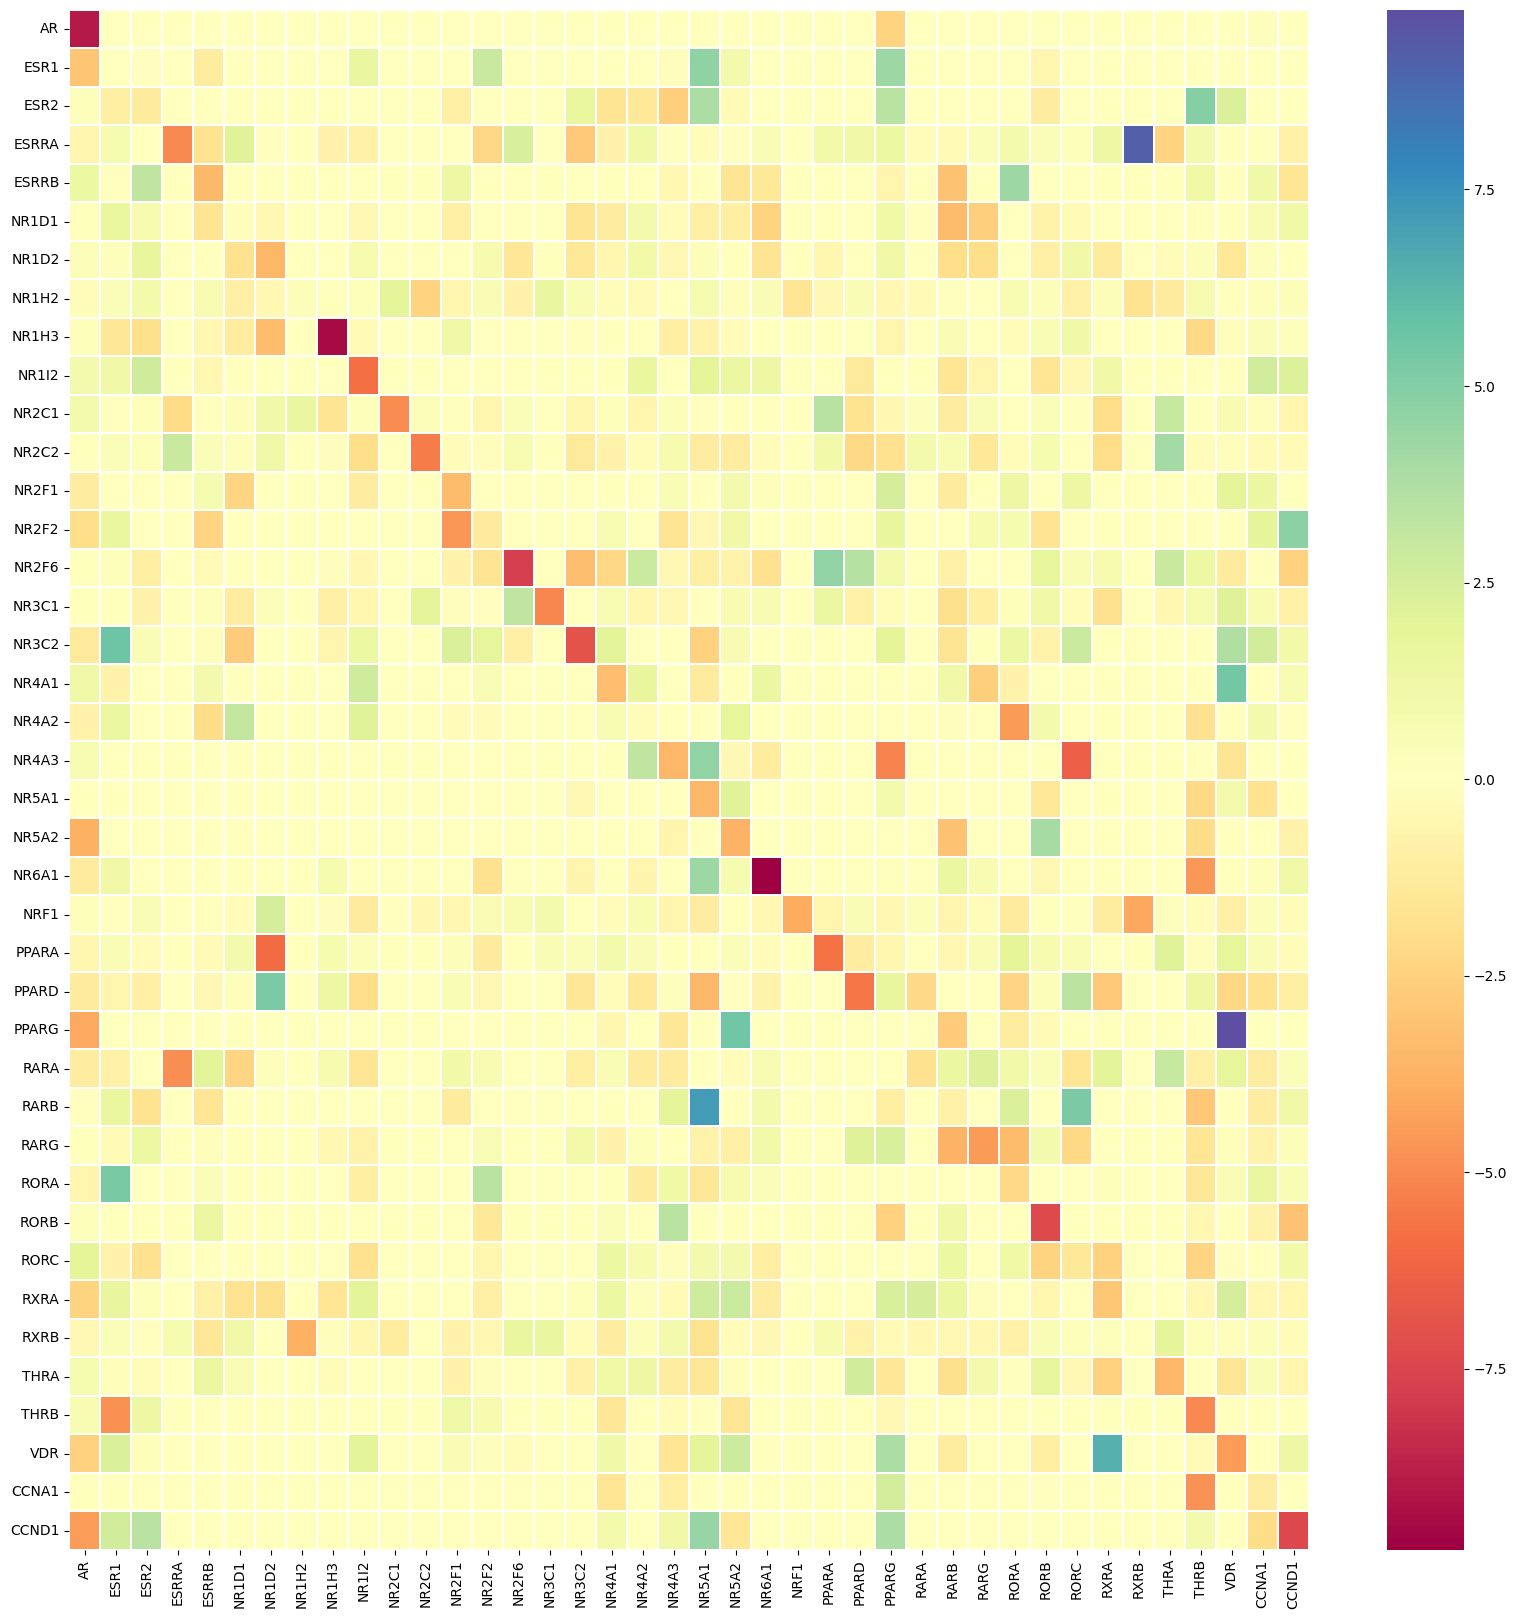

In [ ]:
import seaborn as sn
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 20))
colormap=sn.color_palette("Spectral", as_cmap=True)
hm = sn.heatmap(data = B, linewidths=.05,cmap=colormap)
hm.set_xticklabels(df['Hugo_Symbol'].iloc[filtered_ref_df.index], rotation = 90)
hm.set_yticklabels(df['Hugo_Symbol'].iloc[filtered_ref_df.index], rotation = 0)
# displaying the plotted heatmap
# plt.show()
from pylab import savefig
figure = hm.get_figure()
figure.savefig('recomb_nr_perturb_matrix_ohsu_aml.png', dpi=400)

In [ ]:
import seaborn as sn

fB=B
fB[np.abs(fB)<25]=0

plt.figure(figsize=(20, 20))
colormap=sn.color_palette("Spectral", as_cmap=True)
hm = sn.heatmap(data = fB, linewidths=.05,cmap=colormap)
hm.set_xticklabels(df['Hugo_Symbol'].iloc[filtered_ref_df.index], rotation = 90)
hm.set_yticklabels(df['Hugo_Symbol'].iloc[filtered_ref_df.index], rotation = 0)
# displaying the plotted heatmap
# plt.show()
from pylab import savefig
figure = hm.get_figure()
figure.savefig('filtered_recomb_nr_perturb_matrix_ohsu_aml.png', dpi=400)

Gene network DAG

In [ ]:
def ComputeCorrForGene(x, y):
  return np.corrcoef(x,y)[0,1]

In [ ]:
# input consists of two list of lists, where in both cases each sublist contains a list of rna seq expressions for a given gene
def ComputeCorrs(ref_rna_seqT, path_rna_seqT):
  if len(ref_rna_seqT) != len(path_rna_seqT):
    return [];
  corr_list=[];
  for i in np.arange(len(ref_rna_seqT)):
    x=ref_rna_seqT[i] + path_rna_seqT[i]
    y=[-1 for number in np.arange(len(ref_rna_seqT[i]))] + [1 for number in np.arange(len(path_rna_seqT[i]))]
    corr_list.append(ComputeCorrForGene(x,y))
  return corr_list;

In [ ]:
corr_list=ComputeCorrs(list(map(list, zip(*ref_rna_seq))), list(map(list, zip(*path_rna_seq))))

In [ ]:
# compute digraph where each edge (u,v) has weight corr(u)*C[u,v]
C=np.diag(np.array(corr_list))@B
C[C<0.4]=0

In [ ]:
# select "heaviest" K paths from C of length in (l,L) and draw graph
import itertools

l=3;
L=4;
paths=[];
for i in np.arange(l,L+1):
  for comb in itertools.permutations(np.arange(C.shape[0]), int(i)):
    invalid_path=0
    for j in np.arange(len(comb)-1):
      if C[comb[j+1],comb[j]]==0:
        invalid_path=1
        break;
    if invalid_path==0:
      paths.append(comb)
# sort paths: heaviest path first

In [ ]:
paths

[(0, 1, 36), (26, 38, 9), (26, 38, 39)]

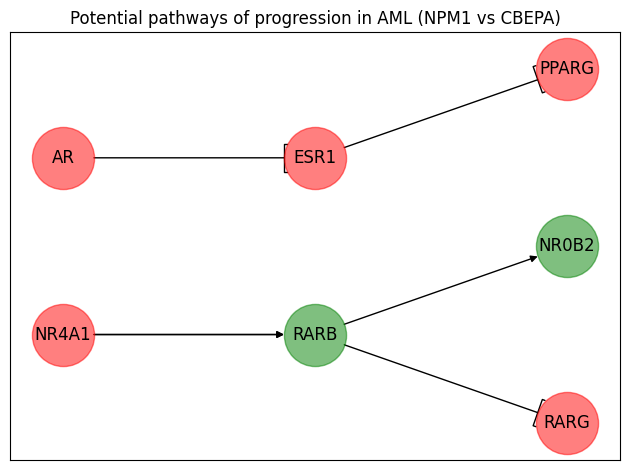

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

G = nx.DiGraph()
neg_edge_list=[]
pos_edge_list=[]
neg_nodes_set=set()
pos_nodes_set=set()
for i in np.arange(min([len(paths),25])):
  for j in np.arange(len(paths[i])-1):
    G.add_edge(nuclear_receptors[paths[i][j]], nuclear_receptors[paths[i][j+1]])
    if B[paths[i][j+1], paths[i][j]] < 0:
      neg_edge_list.append((nuclear_receptors[paths[i][j]], nuclear_receptors[paths[i][j+1]]))
    else:
      pos_edge_list.append((nuclear_receptors[paths[i][j]], nuclear_receptors[paths[i][j+1]]))
    if corr_list[paths[i][j]] < 0:
      neg_nodes_set.add(nuclear_receptors[paths[i][j]])
    else:
      pos_nodes_set.add(nuclear_receptors[paths[i][j]])
    if corr_list[paths[i][j+1]] < 0:
      neg_nodes_set.add(nuclear_receptors[paths[i][j+1]])
    else:
      pos_nodes_set.add(nuclear_receptors[paths[i][j+1]])

for layer, nodes in enumerate(nx.topological_generations(G)):
    # `multipartite_layout` expects the layer as a node attribute, so add the
    # numeric layer value as a node attribute
    for node in nodes:
        G.nodes[node]["layer"] = layer

# Compute the multipartite_layout using the "layer" node attribute
pos = nx.multipartite_layout(G, subset_key="layer")
fig, ax = plt.subplots()
#nx.draw_networkx(G, pos=pos, ax=ax, node_size=2500, node_color='y', alpha=0.5)
nx.draw_networkx_edges(G, pos=pos, edgelist=neg_edge_list, arrowstyle='-[', node_size=2000)
nx.draw_networkx_edges(G, pos=pos, edgelist=pos_edge_list, node_size=2000)
nx.draw_networkx_nodes(G, pos=pos, nodelist=list(pos_nodes_set), node_size=2000, node_color='g', node_shape='o', alpha=0.5)
nx.draw_networkx_nodes(G, pos=pos, nodelist=list(neg_nodes_set), node_size=2000, node_color='r', node_shape='o', alpha=0.5)
nx.draw_networkx_labels(G, pos)
ax.set_title("Potential pathways of progression in AML (NPM1 vs CBEPA)")
fig.tight_layout()
plt.show()
fig.savefig('progression_pathways_ohsu_aml.png', dpi=400)

Cyclin ordering verification

In [ ]:
pip install 'matplotlib<3.7'

In [ ]:
pip install -U scvelo

In [ ]:
import scvelo as scv

In [ ]:
adata = scv.datasets.pancreas()

In [ ]:
scv.pp.filter_genes(adata, min_shared_counts=20)

Filtered out 20801 genes that are detected 20 counts (shared).


In [ ]:
scv.pp.normalize_per_cell(adata)
scv.pp.neighbors(adata, n_neighbors=10)
scv.pp.moments(adata, n_neighbors=10)
scv.tl.recover_dynamics(adata)
scv.tl.latent_time(adata)

Normalized count data: X, spliced, unspliced.
computing neighbors
    finished (0:01:16) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:02) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
recovering dynamics (using 1/2 cores)


  0%|          | 0/1676 [00:00<?, ?gene/s]

    finished (0:15:13) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)
computing velocities
    finished (0:00:03) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/2 cores)


  0%|          | 0/3696 [00:00<?, ?cells/s]

    finished (0:00:05) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing terminal states
    identified 6 regions of root cells and 2 regions of end points .
    finished (0:00:01) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
computing latent time using root_cells as prior
    finished (0:00:03) --> added 
    'latent_time', shared time (adata.obs)


In [ ]:
mus_nuclear_receptors = ['Ar', 'Esr1', 'Esr2', 'Esrra', 'Esrrb', 'Esrrg', 'Hnf4a', 'Hnf4g', 'Nr0b1', 'Nr0b2', 'Nr1d1', 'Nr1d2', 'Nr1h2', 'Nr1h3', 'Nr1h4', 'Nr1i2', 'Nr1i3', 'Nr2c1', 'Nr2c2', 'Nr2e1', 'Nr2e3', 'Nr2f1', 'Nr2f2', 'Nr2f6', 'Nr3c1', 'Nr3c2', 'Nr4a1', 'Nr4a2', 'Nr4a3', 'Nr5a1', 'Nr5a2', 'Nr6a1', 'Nrf1', 'Pgr', 'Ppara', 'Ppard', 'Pparg', 'Rara', 'Rarb', 'Rarg', 'Rora', 'Rorb', 'Rorc', 'Rxra', 'Rxrb', 'Rxrg', 'Thra', 'Thrb', 'Vdr']

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
def SortByLatentTime(list_):
    return list_[len(list_)-1];

In [ ]:
# assumes input is a list of lists with column 0 being the sample ids and
#column nos.; ccna_pos, ccnd_pos being the indices of ccna1 and ccnd1
ccne_pos=20;
ccnd_pos=21;
def SortByStage(list_):
    cell_age = 100*list_[ccne_pos] - 10*list_[ccnd_pos]
    return cell_age;

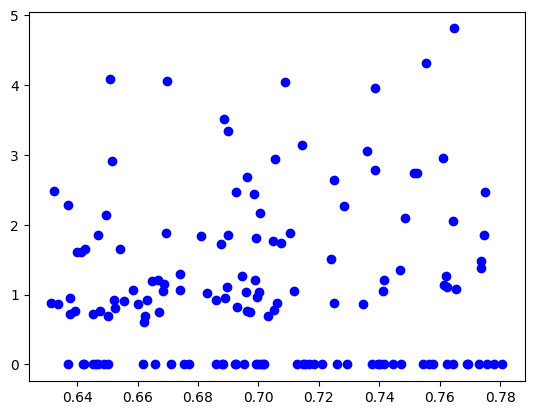

In [ ]:
import matplotlib.pyplot as plt

cyclin_time=adata[beta_cells, ['Ccnk', 'Ccnjl', 'Ccnh', 'Ccng2', 'Ccne2', 'Ccnd3', 'Ccnb1']].X.toarray()
latent_time=adata[beta_cells,:].obs['latent_time'].to_numpy()
#plt.scatter(latent_time, cyclin_time[:,5], color='r')
#plt.scatter(latent_time, cyclin_time[:,2], color='g')
plt.scatter(latent_time, cyclin_time[:,3]+cyclin_time[:,5]+cyclin_time[:,2]+cyclin_time[:,6], color='b')
plt.show()

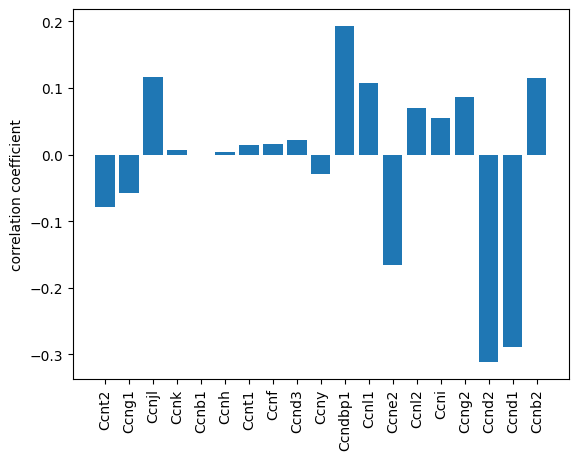

In [ ]:
l = [(e, np.corrcoef(adata[beta_cells, e].X.toarray()[:,0], np.square(adata[beta_cells,:].obs['latent_time'].to_numpy()))[0,1]) for e in [s for s in adata[beta_cells].var.index if 'Ccn' in s]]
cyclin_corrs=list(map(list, zip(*l)))
plt.bar(cyclin_corrs[0], cyclin_corrs[1])
plt.xticks(rotation = 90)
plt.ylabel('correlation coefficient')
plt.savefig('scdata_cyclin_latent_corr.png', dpi=400)

In [ ]:
cluster_name = 'Epsilon'
beta_cells = adata.obs['clusters'] == cluster_name

In [ ]:
Y=np.c_[adata[beta_cells, list(set(adata.var.index.to_list()) & set(mus_nuclear_receptors))].X.toarray(), adata[beta_cells, list(set(adata.var.index.to_list()) & set(mus_nuclear_receptors))].obs['latent_time'].to_numpy()]
Z=Y.tolist()
Z.sort(key=SortByLatentTime)
D_Z=ComputeDiffusivity(Z)

In [ ]:
Y=np.c_[adata[beta_cells, list(set(adata.var.index.to_list()) & set(mus_nuclear_receptors))].X.toarray(), adata[beta_cells, ['Ccne2', 'Ccnd2']].X.toarray()]
Z=Y.tolist()
Z.sort(key=SortByStage)
approxD_Z=ComputeDiffusivity(Z)

In [ ]:
err_Alpha = np.average(np.abs(D_Z-approxD_Z[0:len(D_Z),0:len(D_Z)]))

In [ ]:
err_Beta = np.average(np.abs(D_Z-approxD_Z[0:len(D_Z),0:len(D_Z)]))

In [ ]:
err_Ductal = np.average(np.abs(D_Z-approxD_Z[0:len(D_Z),0:len(D_Z)]))

In [ ]:
err_PE = np.average(np.abs(D_Z-approxD_Z[0:len(D_Z),0:len(D_Z)]))

In [ ]:
err_E = np.average(np.abs(D_Z-approxD_Z[0:len(D_Z),0:len(D_Z)]))

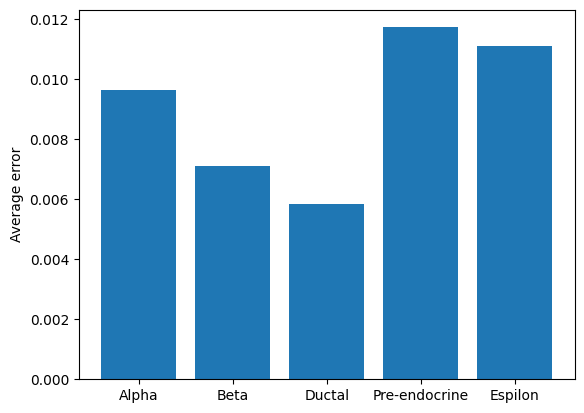

In [ ]:
plt.bar(['Alpha', 'Beta', 'Ductal', 'Pre-endocrine', 'Espilon'], [err_Alpha, err_Beta, err_Ductal, err_PE, err_E])
plt.ylabel('Average error')
plt.savefig('scdata_average_error.png', dpi=400)

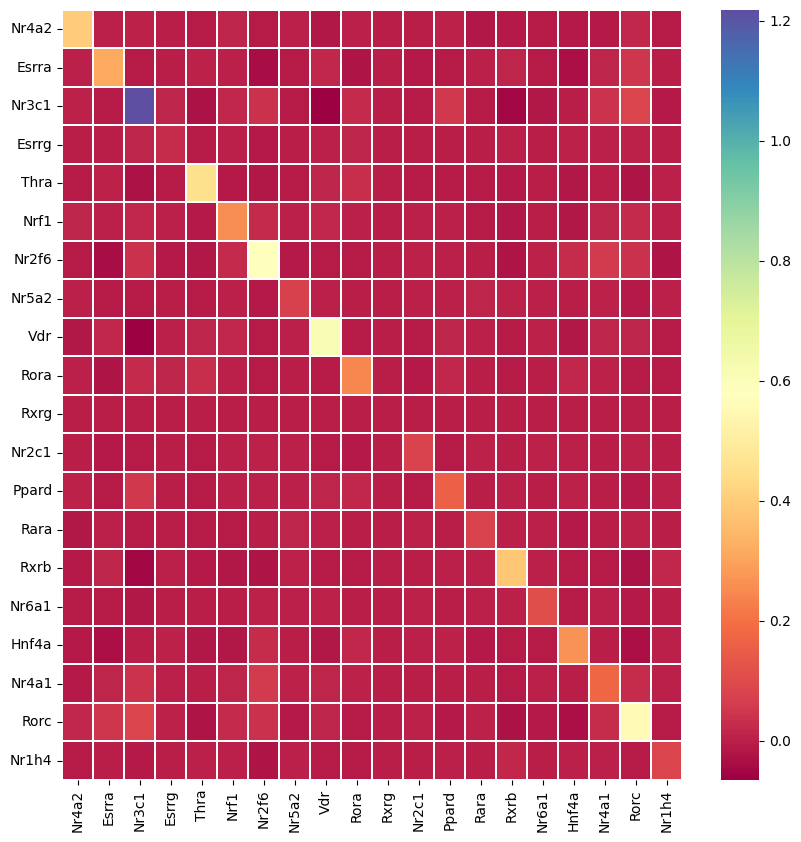

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sn

plt.figure(figsize=(10, 10))
colormap=sn.color_palette("Spectral", as_cmap=True)
hm = sn.heatmap(data = D_Z[0:len(D_Z)-1,0:len(D_Z)-1], linewidths=.05,cmap=colormap)
hm.set_xticklabels(list(set(adata.var.index.to_list()) & set(mus_nuclear_receptors)), rotation = 90)
hm.set_yticklabels(list(set(adata.var.index.to_list()) & set(mus_nuclear_receptors)), rotation = 0)
# displaying the plotted heatmap
# plt.show()
from pylab import savefig
figure = hm.get_figure()
figure.savefig('diffusivity_pancreas_latent_time_beta.png', dpi=400)

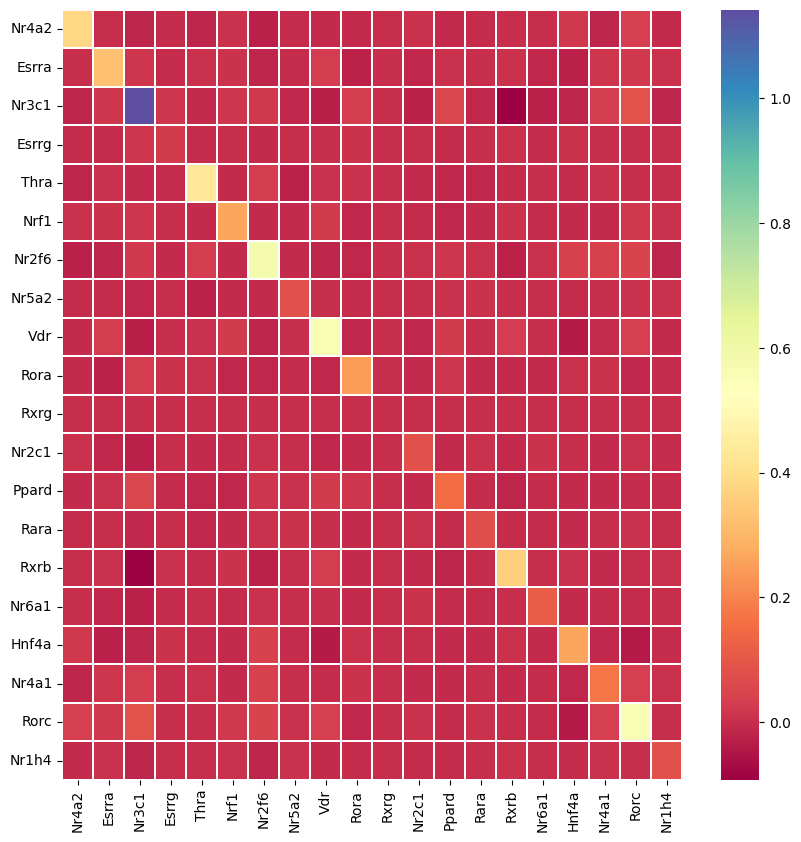

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sn

plt.figure(figsize=(10, 10))
colormap=sn.color_palette("Spectral", as_cmap=True)
hm = sn.heatmap(data = approxD_Z[0:len(D_Z)-1,0:len(D_Z)-1], linewidths=.05,cmap=colormap)
hm.set_xticklabels(list(set(adata.var.index.to_list()) & set(mus_nuclear_receptors)), rotation = 90)
hm.set_yticklabels(list(set(adata.var.index.to_list()) & set(mus_nuclear_receptors)), rotation = 0)
# displaying the plotted heatmap
# plt.show()
from pylab import savefig
figure = hm.get_figure()
figure.savefig('diffusivity_pancreas_cyclins_beta.png', dpi=400)

Misc scratch